# Conversion Rate Prediction
Author: Jacky Li

Problem: Build a Model to prdict conversion rate. Give suggestions on how to prove conversion rate

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

## Preparation

### Import Data

In [4]:
cr_raw = pd.read_csv("conversion_data.csv")
cr_raw.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [5]:
cr_raw.shape#size of dataset

(316200, 6)

In [6]:
cr_raw.info()#type of each column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


### Split training, validation, and testing data

In [7]:
X = cr_raw.drop("converted", axis = 1)
y = cr_raw["converted"]
X_train, X_else, y_train, y_else = train_test_split(X, y, test_size = 0.2)
X_val, X_test, y_val, y_test = train_test_split(X_else, y_else, test_size = 0.5)

## EDA

### Numerical Values

In [8]:
X_train[["age", "total_pages_visited"]].describe()#look at numerical training data

,age,total_pages_visited
count,252960.000000,252960.000000
mean,30.572000,4.874893
std,8.273398,3.343562
min,17.000000,1.000000
25%,24.000000,2.000000
50%,30.000000,4.000000
75%,36.000000,7.000000
max,123.000000,29.000000


In [9]:
age_count = X_train.groupby("age").count()["country"]
print(age_count)

age
17      6091
18      6707
19      7456
20      8149
21      8840
22      9381
23      9872
24     10368
25     10822
26     11083
27     11243
28     11480
29     11368
30     11390
31     10933
32     10789
33     10211
34      9632
35      9168
36      8610
37      7732
38      7150
39      6577
40      5756
41      5162
42      4458
43      3969
44      3409
45      2900
46      2384
47      2026
48      1693
49      1272
50      1087
51       860
52       752
53       523
54       426
55       317
56       230
57       208
58       115
59       100
60        79
61        55
62        41
63        26
64        22
65        12
66         9
67         4
68         4
69         2
70         2
72         1
73         1
77         1
79         1
123        1
Name: country, dtype: int64


Here, age 111 and 123 are the outliers and doesn't make sense in terms of common sense. Since there are only two of these values, we'll remove these two rows from our training set.

In [10]:
#remove two outliers
keep = X_train["age"] < 100
X_train = X_train[keep]
y_train = y_train[keep]

In [11]:
X_train.groupby("total_pages_visited")["age"].count()

total_pages_visited
1     32635
2     35128
3     35004
4     32787
5     28990
6     24154
7     18843
8     14017
9      9736
10     6479
11     4363
12     2887
13     1941
14     1459
15     1053
16      881
17      701
18      571
19      445
20      329
21      237
22      138
23       96
24       33
25       33
26       11
27        5
28        1
29        2
Name: age, dtype: int64

Most people visited the page less than ten times, and the most common value for time visited is 2 and 3.

#### Visualizations

In [14]:
train = pd.concat([X_train.reset_index(drop = True), y_train.reset_index(drop = True)], axis = 1)
age_rate = train.groupby("age")["converted"].sum() / train.groupby("age")["converted"].count()
tpv_rate = train.groupby("total_pages_visited")["converted"].sum() / train.groupby("total_pages_visited")["converted"].count()

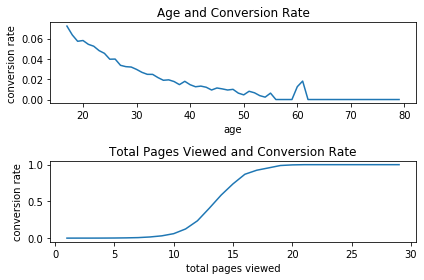

In [15]:
fig, axs = plt.subplots(2)
axs[0].plot(age_rate.index, age_rate)
axs[0].set(xlabel = "age", ylabel = "conversion rate", title = "Age and Conversion Rate")
axs[1].plot(tpv_rate.index, tpv_rate)
axs[1].set(xlabel = "total pages viewed", ylabel = "conversion rate", title = "Total Pages Viewed and Conversion Rate")
fig.tight_layout()
plt.show()

We can see that age is negaively correlated with conversion rate while total pages viewed is positively correlated with conversion rate.

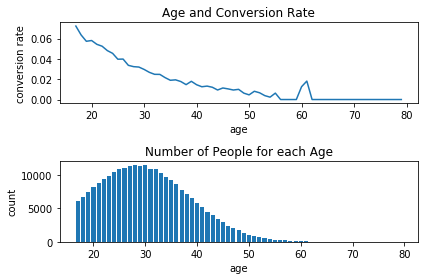

In [16]:
age_count2 = X_train.groupby("age").count()["country"]
fig, axs = plt.subplots(2)
axs[0].plot(age_rate.index, age_rate)
axs[0].set(xlabel = "age", ylabel = "conversion rate", title = "Age and Conversion Rate")
axs[1].bar(age_count2.index, age_count2)
axs[1].set(xlabel = "age", ylabel = "count", title = "Number of People for each Age")
fig.tight_layout()
plt.show()

 The rest of the age data skews to the right and the center is around 28.

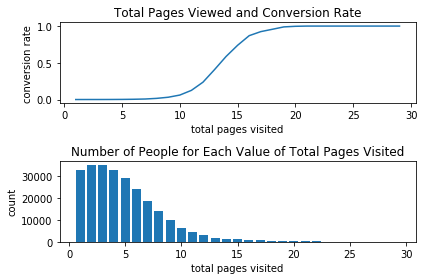

In [17]:
tpv_count = X_train.groupby("total_pages_visited").count()["country"]
fig, axs = plt.subplots(2)
axs[0].plot(tpv_rate.index, tpv_rate)
axs[0].set(xlabel = "total pages visited", ylabel = "conversion rate", title = "Total Pages Viewed and Conversion Rate")
axs[1].bar(tpv_count.index, tpv_count)
axs[1].set(xlabel = "total pages visited", ylabel = "count", title = "Number of People for Each Value of Total Pages Visited")
fig.tight_layout()
plt.show()

### Categorical Values

In [18]:
X_train.groupby("country")["age"].count().sort_values(ascending = False)

country
US         142598
China       61295
UK          38613
Germany     10453
Name: age, dtype: int64

Most users are from the US, followed by China, UK, and Germany

In [19]:
X_train.groupby("new_user")["age"].count().sort_values(ascending = False)

new_user
1    173415
0     79544
Name: age, dtype: int64

The majority of the users documented are new users

In [20]:
X_train.groupby("source")["age"].count().sort_values(ascending = False)

source
Seo       124095
Ads        71037
Direct     57827
Name: age, dtype: int64

Most users are from seo, followed by Ads and Direct

#### Visualizations

In [21]:
country_rate = train.groupby("country")["converted"].sum() / train.groupby("country")["converted"].count()
nu_rate = train.groupby("new_user")["converted"].sum() / train.groupby("new_user")["converted"].count()
nu_rate.index = ["not new user", "new user"]
source_rate = train.groupby("source")["converted"].sum() / train.groupby("source")["converted"].count()

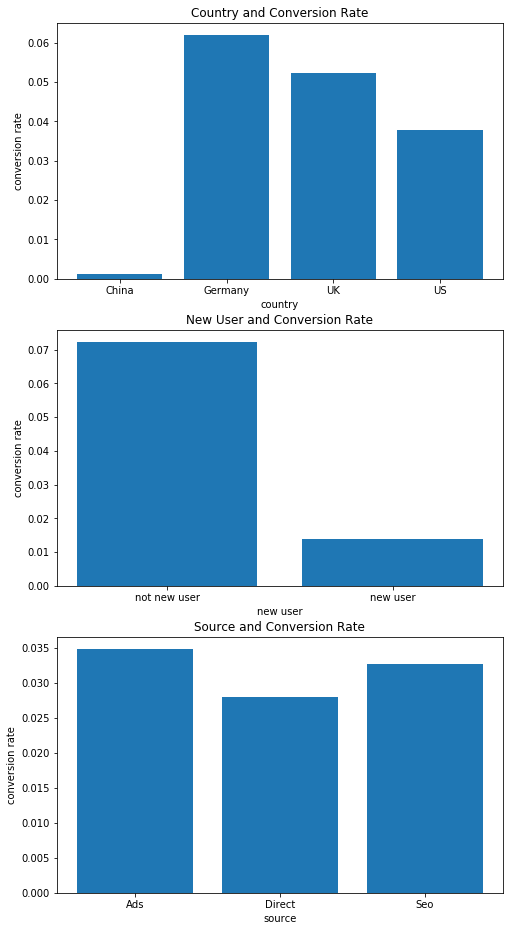

In [22]:
fig, axs = plt.subplots(3, figsize = (8, 16))
axs[0].bar(country_rate.index, country_rate)
axs[0].set(xlabel = "country", ylabel = "conversion rate", title = "Country and Conversion Rate")
axs[1].bar(nu_rate.index, nu_rate)
axs[1].set(xlabel = "new user", ylabel = "conversion rate", title = "New User and Conversion Rate")
axs[2].bar(source_rate.index, source_rate)
axs[2].set(xlabel = "source", ylabel = "conversion rate", title = "Source and Conversion Rate")
plt.show()

China's conversion rate is very low compare to the rest of thee counries. Germany has the highest conversion rate, followed by UK and US.

## Building the model

### Cleaning the Data

In [23]:
print(X_train.isna().sum())
print(y_train.isna().sum())

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
dtype: int64
0


Our training set does not contain missing values.

#### convert categorical data

In [28]:
encoder = OneHotEncoder()
X_train_encoded_par = encoder.fit_transform(X_train[["country", "source"]])

In [29]:
cat_features = encoder.get_feature_names_out(["country", "source"])
X_train_encoded_par = pd.DataFrame(X_train_encoded_par.toarray())
X_train_encoded_par.columns = cat_features

In [30]:
X_train = X_train.reset_index(drop = True) #reset index so the indexs are aligned

In [31]:
X_train_encoded = pd.concat([X_train.drop(["country", "source"], axis = 1), X_train_encoded_par], axis = 1)
X_train_encoded.head()

,age,new_user,total_pages_visited,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,24,1,9,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,43,1,8,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,17,1,4,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,41,1,10,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,19,0,3,0.0,0.0,0.0,1.0,0.0,0.0,1.0


#### Scale the Data

In [32]:
scaler = MinMaxScaler()
X_train_clean = scaler.fit_transform(X_train_encoded)
X_train_clean[:5, ]

array([[0.11290323, 1.        , 0.28571429, 0.        , 0.        ,
        0.        , 1.        , 0.        , 1.        , 0.        ],
       [0.41935484, 1.        , 0.25      , 1.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.10714286, 0.        , 0.        ,
        0.        , 1.        , 0.        , 1.        , 0.        ],
       [0.38709677, 1.        , 0.32142857, 0.        , 0.        ,
        0.        , 1.        , 0.        , 1.        , 0.        ],
       [0.03225806, 0.        , 0.07142857, 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 1.        ]])

In [33]:
#define the function to transform data (for validation and test sets)
def transform_cr (df):
    encoded_par = encoder.transform(df[["country", "source"]])
    encoded_par = pd.DataFrame(encoded_par.toarray())
    encoded_par.columns = cat_features
    df = df.reset_index(drop = True)
    encoded = pd.concat([df.drop(["country", "source"], axis = 1), encoded_par], axis = 1)
    clean = scaler.fit_transform(encoded)
    return clean

### Fit Models

#### Logistic Regression

In [34]:
def fit_get_score(model, x, y):
    model.fit(x, y)
    pred = model.predict(x)
    print("Training accuracy score: ",accuracy_score(y, pred))
def val_predict_get_score(model, x, y):
    pred = model.predict(x)
    print("Validation accuracy score: ",accuracy_score(y, pred))

In [35]:
LR = LogisticRegression()
fit_get_score(LR, X_train_clean, y_train)

Training accuracy score:  0.9860451693752742


In [36]:
LR.coef_

array([[-4.44379397, -1.71279898, 20.45256619, -2.57651415,  1.05605377,
         0.93808165,  0.58192299,  0.08301479, -0.132683  ,  0.04921246]])

In [37]:
X_val_clean = transform_cr(X_val)

In [38]:
val_predict_get_score(LR, X_val_clean, y_val)

Validation accuracy score:  0.984313725490196


Try without regularization

In [39]:
LR_noreg = LogisticRegression(penalty = "none")
fit_get_score(LR_noreg, X_train_clean, y_train)
val_predict_get_score(LR_noreg, X_val_clean, y_val)

Training accuracy score:  0.9861242335714483
Validation accuracy score:  0.9840607210626185


Logistic regression gives a pretty decent result with accuracy score of 0.9843 on the validation set. However, we can get a accuracy score of around 0.97 with a null model (classifing all data as 0s). Let's see if there are other algorithms that can do better

#### SVM

Start off with default C=1

In [40]:
SVM = SVC()
fit_get_score(SVM, X_train_clean, y_train)
val_predict_get_score(SVM, X_val_clean, y_val)

Training accuracy score:  0.9858475088848391
Validation accuracy score:  0.9853573687539532


Try Larger C (=10)

In [41]:
SVM2 = SVC(C = 10)
fit_get_score(SVM2, X_train_clean, y_train)
val_predict_get_score(SVM2, X_val_clean, y_val)

Training accuracy score:  0.9858158832063694
Validation accuracy score:  0.9855471220746364


Try even larger C (=1000)

In [42]:
SVM3 = SVC(C = 1000)
fit_get_score(SVM3, X_train_clean, y_train)
val_predict_get_score(SVM3, X_val_clean, y_val)

Training accuracy score:  0.9857130997513431
Validation accuracy score:  0.9859266287160026


The SVM with C = 1000 has the higher accuracy score on the validation set.

#### Random Forest

In [43]:
RF = RandomForestClassifier(max_depth = 3)
fit_get_score(RF, X_train_clean, y_train)
val_predict_get_score(RF, X_val_clean, y_val)

Training accuracy score:  0.9828786483185022
Validation accuracy score:  0.9852624920936116


In [44]:
RF2 = RandomForestClassifier()
fit_get_score(RF2, X_train_clean, y_train)
val_predict_get_score(RF2, X_val_clean, y_val)

Training accuracy score:  0.9883222182250878
Validation accuracy score:  0.9820050600885516


The RF model where we set the maximum depth to 3 has higher accuracy score on the validation set, but still slightly lower than the SVM with c=1000.

Looks like the third SVM gives the best result in the validation set

## Test Model on Test Set

In [45]:
def test_predict_get_score(model, x, y):
    pred = model.predict(x)
    print("Test accuracy score: ",accuracy_score(y, pred))

In [46]:
print(X_test.isna().sum())
print(y_test.isna().sum())

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
dtype: int64
0


In [48]:
X_test_clean = transform_cr(X_test)
test_predict_get_score(SVM3, X_test_clean, y_test)

Test accuracy score:  0.9860531309297913


Our model(best performing on the validation set) gives an accurate prediction on roughly 98.61% of the data in the test set.

Out of curiosity, let's see what's the accuracy of the Logistic Regression and Random Forest model on the test set

In [49]:
test_predict_get_score(LR, X_test_clean, y_test)

Test accuracy score:  0.9856419987349778


In [53]:
test_predict_get_score(RF, X_test_clean, y_test)

Test accuracy score:  0.9839342188488298


## Conclusion

Suggestions to improve conversion rate/revenue:  
&emsp;1. Conversion rate drops as age gets older. Thus the team can either try to attract more younger people to visit the website or make improvements to the website to better suit for older users.  
&emsp;2. There's a positive correlation between total pages visited and conversion rate. Thus, creating more incentive for user to visit multipl pages might lead to higher conversion rate.  
&emsp;3. The conversion rate for China is extrodinarily low. Considering that China has the second largest user group in the training set, the team need to solve this issue quickly. One way to do so is to conudct a thorough inspection in every point of the conversion process for the Chinese website - from website design to payment channels.  
&emsp;4. Returning users are much more likely to be converted compare to new users. Naturally, the team should implemnt measures to incentivize new users and recall users that has been inactive.  
&emsp;5. Except China, the US has the lowest conversion rate while having the largest user base. This means that focusing on improving conversion rate for the US is likely to have better efficiency.